# Expectation-Maximization

In this programming exercise we will apply the Expectation-Maximization method to estimate the parameters of the latent variable model presented in the theoretical part. The analysis will be performed on one dimension of the Boston Housing dataset, where input values are integers between 0 and 24.

In [1]:
import sklearn,sklearn.datasets

X = sklearn.datasets.load_boston()['data'][:,8]
m = 24
print(X.shape)

(506,)


We restate here the model presented in the theory part. The first distribution $p(z|\theta)$ produces the latent state $z \in \{H,T\}$ which can be interpreted as the head/tail outcome of an (unfair) coin toss, and the following two distributions $p(x \mid z=H,\theta)$, $p(x \mid z=T,\theta)$ produce the observed data $x \in \{0,1,\dots,m\}$ conditioned on outcome of the coin toss $z$. The probability distributions are defined as:

\begin{align*}
	p(z=H \mid \theta) &= \lambda\\
	p(z=T \mid \theta) &= 1 - \lambda\\	
	p(x \mid z=H, \theta) &= \binom{m}{x} a^x (1-a)^{m-x}\\
	p(x \mid z=T, \theta) &= \binom{m}{x} b^x (1-b)^{m-x}
\end{align*}

The vector $\theta = (\lambda,a,b)$ contains the parameters of the model and these parameters need to be learned.

## Computing the Probability Mass Function (15 P)

We first would like to implement a function that computes the probability mass function $p(x|\theta)$ for every value of $x$ between $0$ and $m$.

**Task:**

 * **Implement the function `pmf(lambd,a,b,m)`**

In [8]:
import numpy
from scipy.special import binom

def pmf(lambd,a,b,m):
    
    X = numpy.arange(m+1)
    
    pH = binom(m,X) * a**X * (1-a)**(m-X) * lambd
    pT = binom(m,X) * b**X * (1-b)**(m-X) * (1-lambd)
    
    return pH+pT

'''
# test it
lambd,a,b = 0.5,0.25,0.75
pmf(lambd,a,b,m)
'''

'\n# test it\nlambd,a,b = 0.5,0.25,0.75\npmf(lambd,a,b,m)\n'

## Computing the Log-Likelihood (15 P)

Additionally, we would like to measure the quality of our latent variable model, specifically, the log-likelihood of the data according to the model:

$$
\log p(\mathcal{D}|\theta) = \sum_{x \in \mathcal{D}} \log p(x|\theta)
$$


**Task:**

* **Implement the function below that takes the data and the model parameters as input and returns the log-likelihood.**

In [9]:
def ll(X,lambd,a,b,m):
    
    pH = binom(m,X) * a**X * (1-a)**(m-X) * lambd
    pT = binom(m,X) * b**X * (1-b)**(m-X) * (1-lambd)
   
    return numpy.log(pH+pT).sum()

The code below tests the two functions you have implemented by (1) plotting for a particular choice of parameters $\theta$ the pmf in superposition to the (normalized) data histogram, and (2) printing the log-likelihood of the data according to our model.

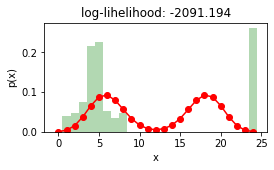

In [10]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import numpy

def plot(data,pdf,ll):
    f = plt.figure(figsize=(4,2))
    plt.hist(data,bins=numpy.arange(m+2)-0.5,alpha=0.3,color='g',density=True)
    plt.plot(range(int(m+1)),pdf,'-o',c='r')
    plt.ylabel('p(x)')
    plt.xlabel('x')
    plt.title('log-lihelihood: %.3f'%ll)
    
lambd,a,b = 0.5,0.25,0.75
plot(X,pmf(lambd,a,b,m),ll(X,lambd,a,b,m))

We observe that the model is not very accurate and the log-likelihood of the data is quite low.

## Implementing and Running the EM Algorithm (20 P)

We now would like to implement the EM algorithm that iteratively searches for optimal parameters $\lambda$, $a$ and $b$. The function starts with some initial parameters that we set at hand. In each iteration, the E-step and the M-step are applied. According to our derivations in the theory part, the E-step and M-step are given by:

*E-Step:*

\begin{align*}
q(z=H|x) &= \gamma \cdot a^x (1-a)^{m-x} \cdot \lambda\\
q(z=T|x) &= \gamma \cdot b^x (1-b)^{m-x} \cdot (1-\lambda)
\end{align*}

with $\gamma$ a normalization constant set to ensure $q(z=H|x)+q(z=T|x)=1$.

*M-Step:*

\begin{align*}
\lambda &= \frac1N \sum_{x \in \mathcal{D}} q(z=H|x) & 
a &= \frac{\sum_{x \in \mathcal{D}} q(z=H|x) \cdot x}{\sum_{x \in \mathcal{D}} q(z=H|x) \cdot m} & 
b &= \frac{\sum_{x \in \mathcal{D}} q(z=T|x) \cdot x}{\sum_{x \in \mathcal{D}} q(z=T|x) \cdot m}
\end{align*}


**Task:**

* **Implement the E-Step and the M-Step.**

In [11]:
def Estep(lambd,a,b,X,m):

    qH = a**X * (1-a)**(m-X) * lambd
    qT = b**X * (1-b)**(m-X) * (1-lambd)
    
    return qH/(qH+qT), qT/(qH+qT)

def Mstep(qH,qT,X,m):

    lambd = qH.mean()
    a = (qH*X).sum()/(qH*m).sum()
    b = (qT*X).sum()/(qT*m).sum()
    
    return lambd,a,b

The code below runs the EM procedure for 4 iterations, starting from some intial parameters chosen at hand, and shows the pdf and the log-likelihood at each iteration.

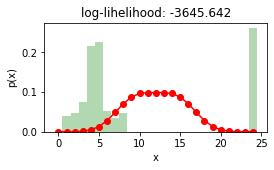

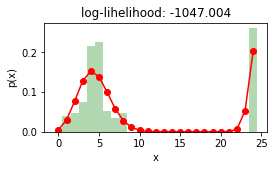

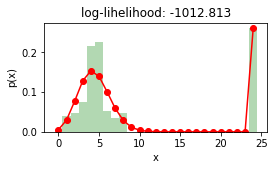

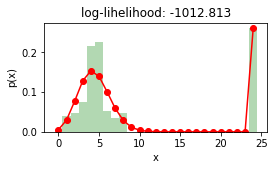

In [12]:
lambd,a,b = 0.5,0.4,0.6

for t in range(4):
    plot(X,pmf(lambd,a,b,m),ll(X,lambd,a,b,m))
    qH,qT = Estep(lambd,a,b,X,m)
    lambd,a,b = Mstep(qH,qT,X,m)

Although the initial choice of parameters is not good, the procedure converges very quickly, and the improvement becomes marginal after only two iterations.